### PROBLEM STATEMENT

Due to the reduction of COE quota, we had seen an increase in the COE premium. As a result, more buyers are turning to the used car market. But the prices for a particular make and model can have a lot of difference in the used car market due to the a few reasons like:
- How old is the car
- Mileage
- Number of owners etc

For this project, we would like to train a model to predict the price of the car so as to let buyers have a guide on how much is the car that they are looking. Here, we will only focus on normal scheme cars.

In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor
from lazypredict.Supervised import LazyRegressor
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

In [146]:
rmse = []
mae = []
mape = []
r_2 = []
def metric_score(y_test, y_pred):
    RMSE = float(format(np.sqrt(mean_squared_error(y_test, y_pred)) , '.3f'))
    MAE = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    MAPE = np.mean(np.abs((y_test-y_pred)/y_test))*100
    rmse.append(RMSE)
    mae.append(MAE)
    r_2.append(r2)
    mape.append(MAPE)
    print('RMSE = ', RMSE, '\nMAE =', MAE, '\nMAPE =', MAPE, '\nR2 =', r2)

### Data Understanding

Import the dataset that we scaped from https://www.stcars.sg/singapore-car/used-cars/search/ (the web scrapping code is in another notebook).

We had a quick glance at the dataset and saw that there are some unexpected missing values stated as **" - "**. We will set them as **NaN** first when importing the dataset using the parameters "na_values"' in pd.read_csv( ).

In [147]:
df = pd.read_csv('Dataset_Chew Hock Boon.csv', na_values='-')

df.head()

,make_model,Price,Registration Date,COE Remaining,Manufactured,Mileage,No. of Owners,Transmission,Engine Capacity,fuel_type,COE,OMV,Paper Value,Depreciation,Type
0,MERCEDES-BENZ C-CLASS C200K (COE TILL 10/2028),"$63,800",19-Dec-2008,7yrs 5mths 13days,2008,"165,000 km",4,Auto,"1,796 cc",NaN,"$32,279","$43,106","$24,081","$8,550 / year",Luxury Sedan
1,NISSAN X-TRAIL 2.0A PREMIUM 7-SEATER SUNROOF,"$81,800",21-Mar-2017,5yrs 10mths 2days,2016,"74,000 km",1,Auto,"1,997 cc",NaN,"$53,300","$23,955","$50,286","$11,810 / year",SUV
2,NISSAN ELGRAND 2.5A HIGHWAY STAR,"$88,000",03-Aug-2016,5yrs 2mths 15days,2016,"82,225 km",1,Auto,"2,488 cc",NaN,"$57,501","$34,974","$60,687","$12,950 / year",MPV
3,MERCEDES-BENZ CLS-CLASS CLS450 MILD HYBRID AMG...,"$367,988",30-Oct-2020,9yrs 5mths 11days,2020,652 km,1,Auto,"2,999 cc",Petrol-Electric,"$32,801","$83,552","$122,808","$32,440 / year",Luxury Sedan
4,TOYOTA HARRIER 2.4A G (COE TILL 09/2029),"$58,500",23-Sep-2009,8yrs 4mths 4days,2008,"174,000 km",5,Auto,"2,362 cc",NaN,"$37,941","$27,778","$31,694","$7,000 / year",SUV


In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7244 entries, 0 to 7243
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   make_model         7244 non-null   object
 1   Price              7244 non-null   object
 2   Registration Date  7244 non-null   object
 3   COE Remaining      7244 non-null   object
 4   Manufactured       7244 non-null   int64 
 5   Mileage            7244 non-null   object
 6   No. of Owners      7244 non-null   object
 7   Transmission       7244 non-null   object
 8   Engine Capacity    7244 non-null   object
 9   fuel_type          732 non-null    object
 10  COE                7244 non-null   object
 11  OMV                7244 non-null   object
 12  Paper Value        7244 non-null   object
 13  Depreciation       7244 non-null   object
 14  Type               7244 non-null   object
dtypes: int64(1), object(14)
memory usage: 849.0+ KB


There are 7244 rows and 15 features:
- **make_model** – make and model of the car
- **Price** – price of the car (our label)
- **Registration Date** – first registration date of the car
- **COE Remaining** – remaining COE of the car
- **Manufactured** – year the car is manufactured
- **Mileage** – mileage of the car in km
- **No. of Owners** – car is owned by how many owner before
- **Transmission** – auto or manual gear
- **Engine Capacity** – engine capacity of the car in c.c
- **fuel_type** – petrol, diesel, petrol – electric
- **COE** – COE premium paid for the car when first registered
- **OMV** – open market value of the car
- **Paper Value** – the amount you get if the car is deregistered
- **Depreciation** – how much the car depreciate per year
- **Type** – type of the car (luxury sedan, MPV, SUV etc)

All features are in data type "object" except **Maunfactured**. We will need to convert some of the features to the data type that we need.

Check for duplicates data and remove them.

In [149]:
print('Duplicated data:', df.duplicated().sum())

Duplicated data: 2015


In [150]:
df.drop_duplicates(inplace=True)

df.shape

(5229, 15)

In [151]:
df.reset_index(drop=True, inplace=True)      # reset the indexes

We left with 5229 rows after removing duplicates rows.

How many **"NaN"** values in the dataset?

In [152]:
df.isna().sum()

make_model              0
Price                   0
Registration Date       0
COE Remaining           0
Manufactured            0
Mileage                 0
No. of Owners           0
Transmission            0
Engine Capacity         0
fuel_type            4700
COE                     0
OMV                     0
Paper Value             0
Depreciation            0
Type                    0
dtype: int64

### Data Cleaning
**1. Handle Missing Values**

Only **fuel_type** has missing values.

In [153]:
df.fuel_type.unique()

array([nan, 'Petrol-Electric', 'Diesel'], dtype=object)

**fuel_type** shows whether the car is using petrol-electronic or diesel. So we can rightly assume that the missing values represent the car is using petrol. We will replace the missing values with "Petrol".

In [154]:
df.fuel_type.fillna('Petrol', inplace=True)

df.head().T

,0,1,2,3,4
make_model,MERCEDES-BENZ C-CLASS C200K (COE TILL 10/2028),NISSAN X-TRAIL 2.0A PREMIUM 7-SEATER SUNROOF,NISSAN ELGRAND 2.5A HIGHWAY STAR,MERCEDES-BENZ CLS-CLASS CLS450 MILD HYBRID AMG...,TOYOTA HARRIER 2.4A G (COE TILL 09/2029)
Price,"$63,800","$81,800","$88,000","$367,988","$58,500"
Registration Date,19-Dec-2008,21-Mar-2017,03-Aug-2016,30-Oct-2020,23-Sep-2009
COE Remaining,7yrs 5mths 13days,5yrs 10mths 2days,5yrs 2mths 15days,9yrs 5mths 11days,8yrs 4mths 4days
Manufactured,2008,2016,2016,2020,2008
Mileage,"165,000 km","74,000 km","82,225 km",652 km,"174,000 km"
No. of Owners,4,1,1,1,5
Transmission,Auto,Auto,Auto,Auto,Auto
Engine Capacity,"1,796 cc","1,997 cc","2,488 cc","2,999 cc","2,362 cc"
fuel_type,Petrol,Petrol,Petrol,Petrol-Electric,Petrol


**2. Convert features data type**

We will convert **Price, COE, OMV and Paper Value** together.

In [155]:
to_int = ['Price', 'COE', 'OMV', 'Paper Value']      

In [156]:
for item in to_int:
    df[item] = [int(item.replace('$', '').replace(',', '')) for item in df[item]]

Covert **COE Remaining** into number of months.

In [157]:
remaining = []

for item in df['COE Remaining']:
    item = item.split()
    if len(item) == 3:
        if len(item[1]) == 6:
            remaining.append((int(item[0][0])*12)+int(item[1][0]+item[1][1]))
        else:
            remaining.append((int(item[0][0])*12)+int(item[1][0]))
    else:
        remaining.append(int(item[0][0])/12)

In [158]:
df['COE Remaining'] = remaining
df['COE Remaining'].head()

0     89
1     70
2     62
3    113
4    100
Name: COE Remaining, dtype: int64

Convert **Mileage**.

In [159]:
df['Mileage'] = [int(item.replace('km', '').replace(',', '')) for item in df.Mileage]
df.Mileage.head()

0    165000
1     74000
2     82225
3       652
4    174000
Name: Mileage, dtype: int64

Convert **No. of Owners**.

In [160]:
df['No. of Owners'] = [int(item[-1]) for item in df['No. of Owners']]
df['No. of Owners'].head()

0    4
1    1
2    1
3    1
4    5
Name: No. of Owners, dtype: int64

Convert **Engine Capacity**.

In [161]:
df['Engine Capacity'].sort_values(ascending=False)

177     Electric
2149    Electric
829     Electric
2475    Electric
850     Electric
          ...   
3365    1,193 cc
3599    1,193 cc
1175    1,086 cc
2373    1,086 cc
4960    1,086 cc
Name: Engine Capacity, Length: 5229, dtype: object

As shown above, there are values like "Electric" in **Engine Capacity**. This is because electric cars like Tesla has no engine capacity. We will create another feature name **electric** before we convert **Engine Capacity**.

In [162]:
 # create a copy of Engine Capacity

electric = df['Engine Capacity'].copy()

In [163]:
for i in range(len(electric)):
    if electric[i] != 'Electric':
        electric[i] = 'No'

In [164]:
df['electric'] = electric
df.electric.head()

0    No
1    No
2    No
3    No
4    No
Name: electric, dtype: object

In [165]:
df['Engine Capacity'] = [int(item.replace('cc', '').replace(',', '').replace('Electric', '0')) \
                         for item in df['Engine Capacity']]
df['Engine Capacity'].head()

0    1796
1    1997
2    2488
3    2999
4    2362
Name: Engine Capacity, dtype: int64

Since electric cars are electric driven, so we have to replace the **fuel_type** to electric.

In [166]:
fuel = df[df.electric=='Electric']

In [167]:
fuel['fuel_type'] = [item.replace('Petrol', 'Electric') for item in fuel['fuel_type']]

In [168]:
# drop those rows that are electric cars from df

df.drop(fuel.index, inplace=True)

In [169]:
# concate df with fuel

df = pd.concat([df, fuel], ignore_index=True)

In [170]:
df.shape

(5229, 16)

In [171]:
df.reset_index(drop=True, inplace=True)

Convert **Depreciation**.

In [172]:
df['Depreciation'] = [int(item[:7].replace('$', '').replace(',', '')) for item in df.Depreciation]
df.Depreciation.head()

0     8550
1    11810
2    12950
3    32440
4     7000
Name: Depreciation, dtype: int64

In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5229 entries, 0 to 5228
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   make_model         5229 non-null   object
 1   Price              5229 non-null   int64 
 2   Registration Date  5229 non-null   object
 3   COE Remaining      5229 non-null   int64 
 4   Manufactured       5229 non-null   int64 
 5   Mileage            5229 non-null   int64 
 6   No. of Owners      5229 non-null   int64 
 7   Transmission       5229 non-null   object
 8   Engine Capacity    5229 non-null   int64 
 9   fuel_type          5229 non-null   object
 10  COE                5229 non-null   int64 
 11  OMV                5229 non-null   int64 
 12  Paper Value        5229 non-null   int64 
 13  Depreciation       5229 non-null   int64 
 14  Type               5229 non-null   object
 15  electric           5229 non-null   object
dtypes: int64(10), object(6)
memory usage: 653.

We will separate **make_model** into 2 features - **make** and **model**.

In [174]:
make = []
for item in df.make_model:
    item = item.split()
    if 'ALFA' in item or 'ROVER' in item or 'ASTON' in item:
        make.append(item[0]+' '+item[1])
    else:
        make.append(item[0])

In [175]:
df.insert(0, 'make', make)

We will replace **Registration Date** with **car_age**.

In [176]:
df['Registration Date'] = [pd.Timestamp.now().year-int(item[-4:]) for item in df['Registration Date']]
df['Registration Date'].head()

0    13
1     4
2     5
3     1
4    12
Name: Registration Date, dtype: int64

In [177]:
# rename the features

df.rename(columns={'make_model':'model', 'Registration Date':'car_age'}, inplace=True)

### Exploratory Data Analysis

**Brands of car on the website:**

In [178]:
count = df.make.value_counts()

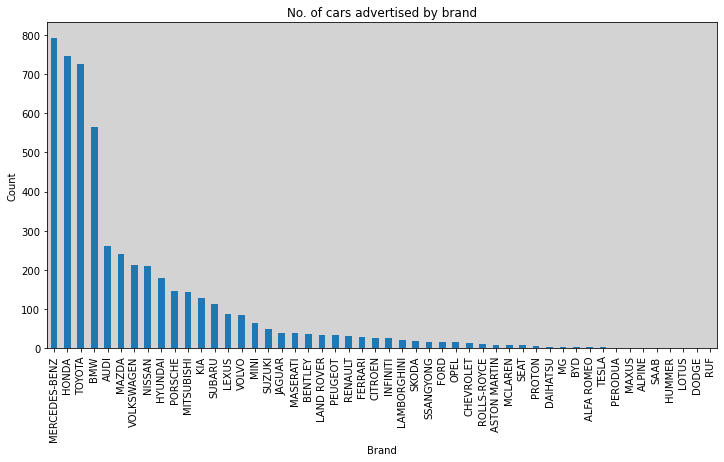

In [179]:
count.plot(kind='bar', figsize=(12,6), title='No. of cars advertised by brand')
plt.axes().set_facecolor('lightgrey')
plt.xlabel('Brand')
plt.ylabel('Count')

plt.show()

We are not surprised to see that out of the total cars that are advertised, Mercedes, Honda, Toyota and BMW combined to have more than half as from the statistics we found on data.gov.sg (https://data.gov.sg/dataset/annual-car-population-by-make?view_id=35537b34-3656-4a5d-a37d-3bab1672f80d&resource_id=08f7cf29-60aa-4da0-9e79-8c139a70c91e), these 4 brands already had a huge market shares since 2005.

**The car age of each brand:**

In [180]:
# create a list for the pie chart

avg = []

for item in df.car_age:
    if item < df.car_age.mean():
        avg.append('less')
    else:
        avg.append('more')

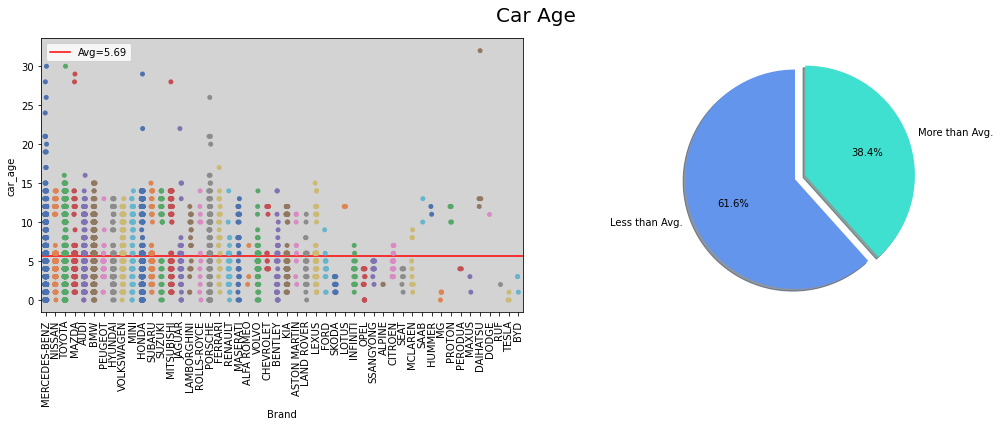

In [181]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.suptitle('Car Age', fontsize=20)

sns.stripplot(x=df.make, y=df.car_age, palette='deep', ax=ax[0])

for label in ax[0].get_xticklabels():
    label.set_rotation(90)
    
ax[0].set_facecolor('lightgrey')
ax[0].set_xlabel('Brand')
ax[0].axhline(y=df.car_age.mean(), linestyle='-', color='r', label='Avg={}'.format(round(df.car_age.mean(), 2)))
ax[0].legend()

ax[1].pie(x=np.unique(avg, return_counts=True)[1], explode=(0.1,0), labels=['Less than Avg.', 'More than Avg.'], 
          autopct='%.1f%%', startangle=90, shadow=True, colors=['cornflowerblue', 'turquoise'])

plt.tight_layout()

The age distribution of most brand are very wide. There are even vintage cars (more than 20 years)! The average age of the cars on the website are below 6 year and most of them are below the average.

**The type of cars:**

In [182]:
type_count = df.Type.value_counts()

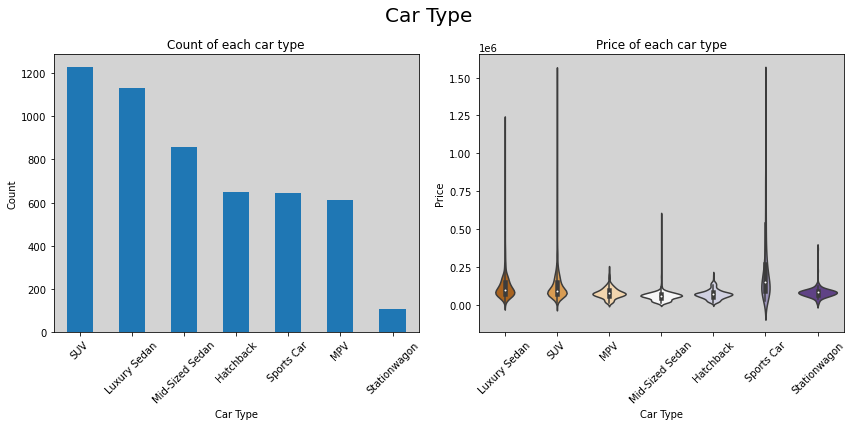

In [183]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle('Car Type', fontsize=20)

[ax[i].set_facecolor('lightgrey') for i in range(2)]

type_count.plot(kind='bar', title='Count of each car type', ax=ax[0])
ax[0].set_xlabel('Car Type')
ax[0].set_ylabel('Count')

for label in ax[0].get_xticklabels():
    label.set_rotation(45)

sns.violinplot(x=df.Type, y=df.Price, palette='PuOr', ax=ax[1])

for label in ax[1].get_xticklabels():
    label.set_rotation(45)

ax[1].set_title('Price of each car type')
ax[1].set_xlabel('Car Type')

plt.tight_layout()

Surprisingly, SUV is the second most commom type of car on the website (Luxury Sedan and Mid-Size Sedan are still sedan car. Difference is just the brand). Is it the sales of new SUV car has increased in the past few years? Due to the brand (like Roll-Royces), we can see that the price of some car types can go as high as over \\$1 millions (for a used car?!) but most of them are still around the average price range. Notice that the highest price for Mid-Sized Sedan is above $500k. From our understanding, there are no Mid-Sized Sedan brand that have price that go that high (not even their new car). Seems like some of the car type are mixed up.

**Does OMV tell us anything about the car:**

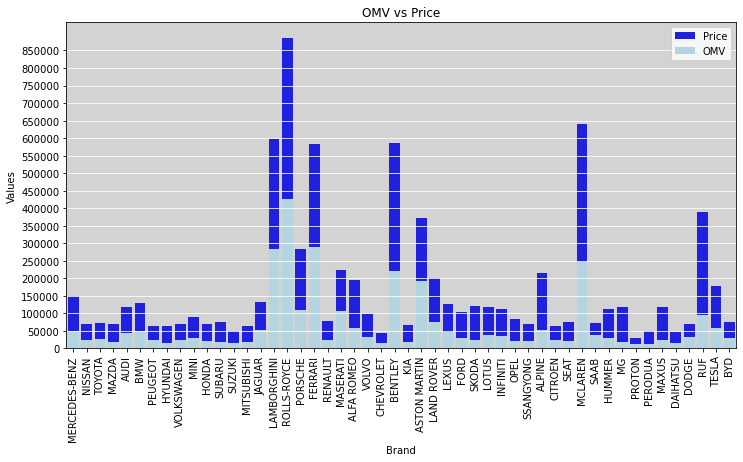

In [184]:
plt.figure(figsize=(12,6))
plt.axes().set_facecolor('lightgrey')

sns.barplot(x=df.make, y=df.Price, color='Blue', ci=None)
sns.barplot(x=df.make, y=df.OMV, color=('lightblue'), ci=None)

plt.title('OMV vs Price')
plt.xlabel('Brand')
plt.xticks(rotation=90)
plt.ylabel('Values')
plt.yticks(np.arange(0, 900000, 50000))
plt.grid(axis='y', color='white')
plt.legend(['Price', 'OMV'])

plt.show()

We can see that those cars with **OMV** of \\$100k and above are those exotic brands like Rolls-Royce, Ferari, Lamborghini etc. Therefore in some way the **OMV** can roughly tell us if the car is from an exotic brand. Also, we can see that car price is about at least 1.5 times the omv of the car. 

**How Price is affected by mileage and age:**

We will compare using same brand and model.

In [185]:
df.model.value_counts().head(1)

HONDA VEZEL 1.5A X    93
Name: model, dtype: int64

In [186]:
same_model = df[df.model=='HONDA VEZEL 1.5A X']

In [187]:
sort_age = same_model.sort_values(by=['car_age'])

In [188]:
sort_age['dist_bin'] = pd.cut(x=sort_age.Mileage, bins=np.arange(0, 140000, 5000), 
                              labels=['0-5000', '5001-10000', '10001-15000', '15001-20000', '20001-25000', '25001-30000', 
                                      '30001-35000', '35001-40000', '40001-45000', '45001-50000', '50001-55000', 
                                      '55001-60000', '60001-65000', '65001-70000', '70001-75000', '75001-80000', 
                                      '80001-85000', '85001-90000', '90001-95000', '95001-100000', '100001-105000', 
                                      '105001-110000', '110001-115000', '115001-120000', '120001-125000', '125001-130000', 
                                      '130001-135000'])

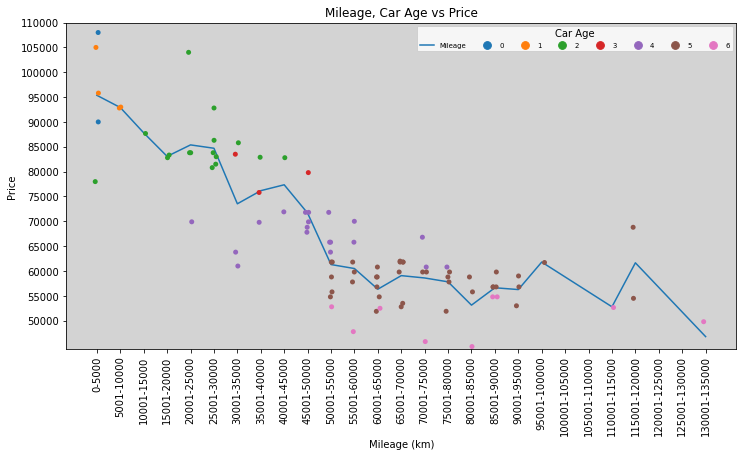

In [189]:
plt.figure(figsize=(12,6))
plt.axes().set_facecolor('lightgrey')

sns.stripplot(x=sort_age.dist_bin, y=sort_age.Price, hue=sort_age.car_age)
sns.lineplot(x=sort_age.dist_bin, y=sort_age.Price, ci=None, label='Mileage')

plt.title('Mileage, Car Age vs Price')
plt.xlabel('Mileage (km)')
plt.xticks(rotation=90)
plt.yticks(np.arange(50000, 115000, 5000))
plt.legend(title='Car Age', ncol=8, fontsize='x-small')

plt.show()

We can see that most of the car price is highly affected by car age and mileage. The price is lower if the car is older or with higher mileage.

### Data Pre-processing

Before we pre-process the data, we have to correct the car type that are mixed up. After some research, we set the price threshold of Mid-Sized Sedan at $150k.

In [190]:
type_error = df[(df.Type=='Mid-Sized Sedan') & (df.Price>150000)]
type_error.T

,316,435,505,553,1324,2097,2526,2610,3333,4971
make,TOYOTA,TOYOTA,MERCEDES-BENZ,MERCEDES-BENZ,PORSCHE,SKODA,PORSCHE,BMW,AUDI,SKODA
model,TOYOTA HARRIER HYBRID G,TOYOTA GR SUPRA 3.0A PRO,MERCEDES-BENZ GLB-CLASS GLB200 AMG LINE,MERCEDES-BENZ GLE-CLASS GLE250D AMG LINE 4MATI...,PORSCHE 911 CARRERA S COUPE 3.0A PDK,SKODA OCTAVIA 2.0A TSI RS,PORSCHE PANAMERA V6 3.6A PLATINUM EDITION PDK,BMW I8,AUDI A6 MILD HYBRID 2.0A TFSI S-TRONIC DESIGN,SKODA OCTAVIA ESTATE 2.0A VRS
Price,179988,250000,187800,212000,588088,168168,193000,488000,186800,158800
car_age,0,1,0,3,1,1,8,1,1,2
COE Remaining,115,104,116,91,115,110,23,106,104,100
Manufactured,2020,2019,2020,2018,2020,2019,2012,2017,2019,2019
Mileage,88,9000,28,35000,1101,9117,30000,10000,19000,29000
No. of Owners,1,1,1,1,1,1,2,1,1,1
Transmission,Auto,Auto,Auto,Auto,Auto,Auto,Auto,Auto,Auto,Auto
Engine Capacity,2487,2998,1332,2143,2981,1984,3605,1499,1984,1984


In [191]:
# change the car type

type_error['Type'] = ['SUV', 'Sports Car', 'SUV', 'SUV', 'Sports Car', 'Mid-Sized Sedan', 'Sports Car', 'Sports Car', 
                      'Luxury Sedan', 'Mid-Sized Sedan']

In [192]:
# drop from the main dataset (df)

df.drop(type_error.index, inplace=True)

In [193]:
# join the corrected dataset (type_error) back to main dataset (df)

df = pd.concat([df, type_error], ignore_index=True)
df.shape

(5229, 17)

In [194]:
df.reset_index(drop=True, inplace=True)

In [195]:
# create a copy for later use

df_copy = df.copy()

We have 50 variables in feature **make**. We will group them into 2 groups: **europe** and **others**. 

In [196]:
df.make.unique()

array(['MERCEDES-BENZ', 'NISSAN', 'TOYOTA', 'MAZDA', 'AUDI', 'BMW',
       'PEUGEOT', 'HYUNDAI', 'VOLKSWAGEN', 'MINI', 'HONDA', 'SUBARU',
       'SUZUKI', 'MITSUBISHI', 'JAGUAR', 'LAMBORGHINI', 'ROLLS-ROYCE',
       'PORSCHE', 'FERRARI', 'RENAULT', 'MASERATI', 'ALFA ROMEO', 'VOLVO',
       'CHEVROLET', 'BENTLEY', 'KIA', 'ASTON MARTIN', 'LAND ROVER',
       'LEXUS', 'FORD', 'SKODA', 'LOTUS', 'INFINITI', 'OPEL', 'SSANGYONG',
       'ALPINE', 'CITROEN', 'SEAT', 'MCLAREN', 'SAAB', 'HUMMER', 'MG',
       'PROTON', 'PERODUA', 'MAXUS', 'DAIHATSU', 'DODGE', 'RUF', 'TESLA',
       'BYD'], dtype=object)

In [197]:
europe = ['MERCEDES-BENZ', 'AUDI', 'BMW', 'PEUGEOT', 'VOLKSWAGEN', 'MINI', 'JAGUAR', 'LAMBORGHINI', 'ROLLS-ROYCE', 
          'PORSCHE', 'FERRARI', 'RENAULT', 'MASERATI', 'ALFA ROMEO', 'VOLVO', 'BENTLEY', 'ASTON MARTIN', 'LAND ROVER', 
          'SKODA', 'LOTUS', 'OPEL', 'ALPINE', 'CITROEN', 'SEAT', 'MCLAREN', 'SAAB', 'HUMMER', 'MG', 'RUF']

In [198]:
brand = []

for item in df.make:
    if item in europe:
        brand.append('europe')
    else:
        brand.append('others')

In [199]:
df['make'] = brand

In [200]:
df.head()

,make,model,Price,car_age,COE Remaining,Manufactured,Mileage,No. of Owners,Transmission,Engine Capacity,fuel_type,COE,OMV,Paper Value,Depreciation,Type,electric
0,europe,MERCEDES-BENZ C-CLASS C200K (COE TILL 10/2028),63800,13,89,2008,165000,4,Auto,1796,Petrol,32279,43106,24081,8550,Luxury Sedan,No
1,others,NISSAN X-TRAIL 2.0A PREMIUM 7-SEATER SUNROOF,81800,4,70,2016,74000,1,Auto,1997,Petrol,53300,23955,50286,11810,SUV,No
2,others,NISSAN ELGRAND 2.5A HIGHWAY STAR,88000,5,62,2016,82225,1,Auto,2488,Petrol,57501,34974,60687,12950,MPV,No
3,europe,MERCEDES-BENZ CLS-CLASS CLS450 MILD HYBRID AMG...,367988,1,113,2020,652,1,Auto,2999,Petrol-Electric,32801,83552,122808,32440,Luxury Sedan,No
4,others,TOYOTA HARRIER 2.4A G (COE TILL 09/2029),58500,12,100,2008,174000,5,Auto,2362,Petrol,37941,27778,31694,7000,SUV,No


We will drop **model** since **OMV, Engine Capacity** and **fuel_type** can somehow describe the car (is it exotic? is it petrol, diesel, elctric driven?). 

In [201]:
df.drop('model', axis=1, inplace=True)

In [202]:
df.head()

,make,Price,car_age,COE Remaining,Manufactured,Mileage,No. of Owners,Transmission,Engine Capacity,fuel_type,COE,OMV,Paper Value,Depreciation,Type,electric
0,europe,63800,13,89,2008,165000,4,Auto,1796,Petrol,32279,43106,24081,8550,Luxury Sedan,No
1,others,81800,4,70,2016,74000,1,Auto,1997,Petrol,53300,23955,50286,11810,SUV,No
2,others,88000,5,62,2016,82225,1,Auto,2488,Petrol,57501,34974,60687,12950,MPV,No
3,europe,367988,1,113,2020,652,1,Auto,2999,Petrol-Electric,32801,83552,122808,32440,Luxury Sedan,No
4,others,58500,12,100,2008,174000,5,Auto,2362,Petrol,37941,27778,31694,7000,SUV,No


Split the dataset into X (features) and y (label).

In [203]:
X = df.drop('Price', axis=1)
y = df.Price

Check the outliers of the features:

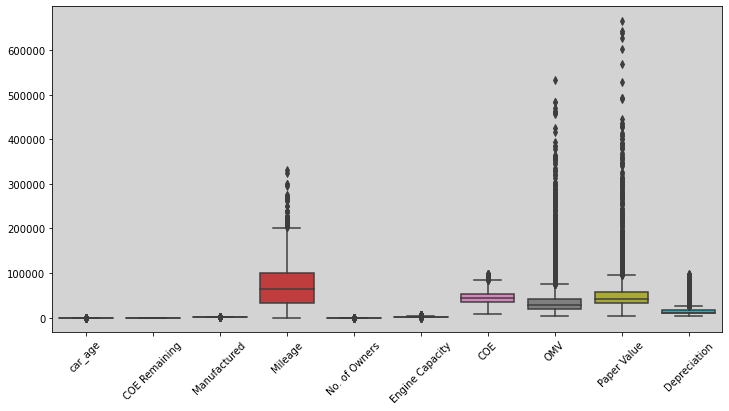

In [204]:
plt.figure(figsize=(12,6))

sns.boxplot(data=X)

plt.axes().set_facecolor('lightgrey')
plt.xticks(rotation=45)

plt.show()

There are a lot of outliers in **Mileage, COE, OMV, Paper Value and Depreciation**. All these outliers are related to the car usage and brands and we will keep them.

Check the distribution of the features.

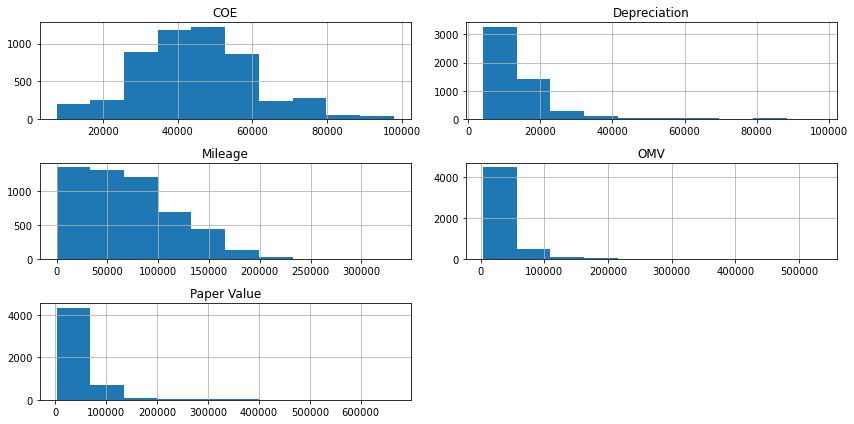

In [205]:
skewed = ['Mileage', 'COE', 'OMV', 'Paper Value', 'Depreciation']

X.hist(skewed, figsize=(12,6))

plt.tight_layout()

Other then **COE**, the rest are right skewd. We will adjust thier distribution using $log$. 

In [206]:
for item in skewed:
    if item != 'COE':
        X[item] = np.log(X[item])

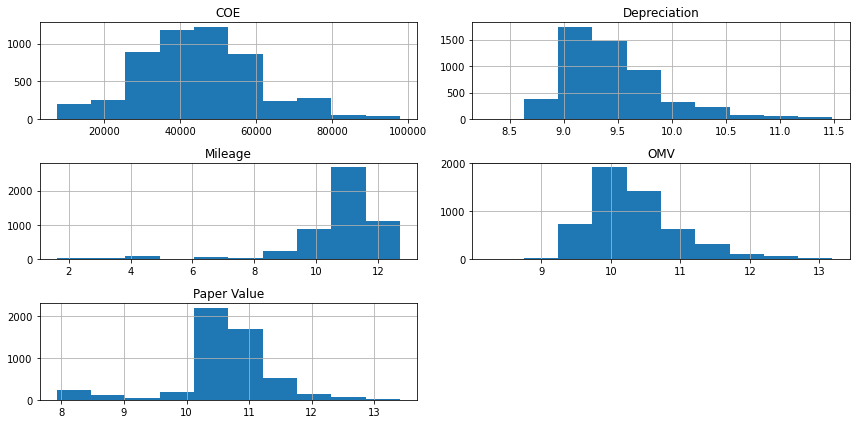

In [207]:
X.hist(skewed, figsize=(12,6))

plt.tight_layout()

Convert categorical features to numerical features.
- use Dummies Encoding for **make, Transmission, fuel_type, electric**

In [208]:
X = pd.get_dummies(X, columns=['make', 'Transmission', 'fuel_type', 'electric'], drop_first=True)
X.head().T

,0,1,2,3,4
car_age,13,4,5,1,12
COE Remaining,89,70,62,113,100
Manufactured,2008,2016,2016,2020,2008
Mileage,12.01,11.21,11.32,6.48,12.07
No. of Owners,4,1,1,1,5
Engine Capacity,1796,1997,2488,2999,2362
COE,32279,53300,57501,32801,37941
OMV,10.67,10.08,10.46,11.33,10.23
Paper Value,10.09,10.83,11.01,11.72,10.36
Depreciation,9.05,9.38,9.47,10.39,8.85


- use Frequency Encoding for **Type**

In [209]:
count_type = X.Type.value_counts()

In [210]:
encoding = count_type/len(X.Type)
X['type_enc'] = X.Type.map(encoding)

X.head().T

,0,1,2,3,4
car_age,13,4,5,1,12
COE Remaining,89,70,62,113,100
Manufactured,2008,2016,2016,2020,2008
Mileage,12.01,11.21,11.32,6.48,12.07
No. of Owners,4,1,1,1,5
Engine Capacity,1796,1997,2488,2999,2362
COE,32279,53300,57501,32801,37941
OMV,10.67,10.08,10.46,11.33,10.23
Paper Value,10.09,10.83,11.01,11.72,10.36
Depreciation,9.05,9.38,9.47,10.39,8.85


In [211]:
X.drop('Type', axis=1, inplace=True)

Split the dataset into train and test sets.

In [212]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31)

Perform Feature Scaling on **car_age, COE Remaining, Manufactured, Mileage, No. of Owners, Engine Capacity, COE, OMV, Paper Value** and **Depreciation**.

In [213]:
X_train_scale = X_train.copy()
X_test_scale = X_test.copy()

In [214]:
# get the features name that we are scaling.

col_to_scale = X.columns[:10]

In [215]:
standardscaler = StandardScaler()

for item in col_to_scale:
    X_train_scale[item] = standardscaler.fit_transform(X_train[[item]])
    X_test_scale[item] = standardscaler.fit_transform(X_test[[item]])

In [216]:
X_train_scale.head().T

,3630,827,1911,3965,1647
car_age,-0.93,1.84,-0.17,0.08,-1.18
COE Remaining,0.94,0.42,-0.58,-0.80,1.27
Manufactured,1.05,-1.75,0.29,0.03,1.05
Mileage,-0.40,0.70,0.02,0.41,-1.64
No. of Owners,-0.70,1.76,-0.70,-0.70,-0.70
Engine Capacity,-0.57,2.25,1.27,-0.94,5.67
COE,-0.87,-0.66,0.30,0.68,-0.50
OMV,-0.37,1.46,1.34,-0.79,3.73
Paper Value,-0.07,-0.60,1.12,-0.23,3.16
Depreciation,-0.72,1.63,1.93,-0.46,-0.47


Perform a multicollinearity check to see any correlations between features.

In [217]:
cor = X_train_scale.corr()

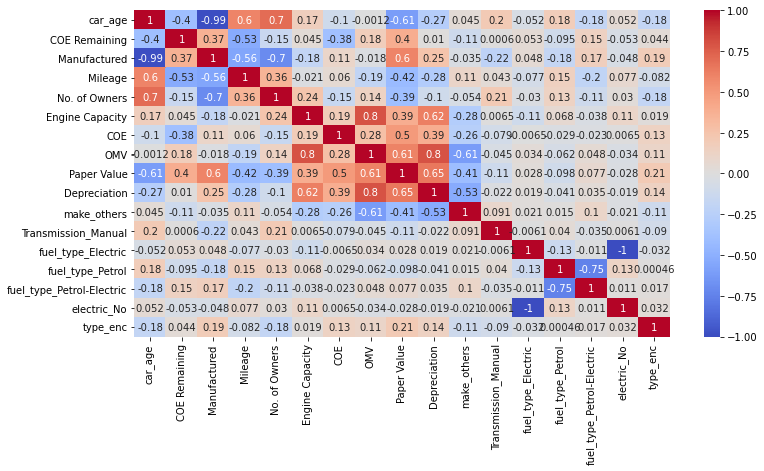

In [218]:
plt.figure(figsize=(12,6))
sns.heatmap(cor, annot=True, cmap='coolwarm')
plt.savefig('corr.png')

From the heatmap, we can see that:
- Highly correlated (> 0.8 or < -0.8):
    - **Manufactured, car_age**
    - **electric_No, fuel_type_Electric**

We will drop **Manufactured** and **electric_No**.

In [219]:
X_train_scale.drop(['Manufactured', 'electric_No'], axis=1, inplace=True)
X_test_scale.drop(['Manufactured', 'electric_No'], axis=1, inplace=True)

In [220]:
X_train_scale.head().T

,3630,827,1911,3965,1647
car_age,-0.93,1.84,-0.17,0.08,-1.18
COE Remaining,0.94,0.42,-0.58,-0.80,1.27
Mileage,-0.40,0.70,0.02,0.41,-1.64
No. of Owners,-0.70,1.76,-0.70,-0.70,-0.70
Engine Capacity,-0.57,2.25,1.27,-0.94,5.67
COE,-0.87,-0.66,0.30,0.68,-0.50
OMV,-0.37,1.46,1.34,-0.79,3.73
Paper Value,-0.07,-0.60,1.12,-0.23,3.16
Depreciation,-0.72,1.63,1.93,-0.46,-0.47
make_others,1.00,1.00,0.00,1.00,0.00


###  Training the models

We will use Lazy Predict to see which basic model work the best.

In [221]:
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None, random_state=31)
models, predictions = reg.fit(X_train_scale, X_test_scale, y_train, y_test)

100%|██████████| 42/42 [00:17<00:00,  2.36it/s]


In [222]:
print(models)

                               Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
ExtraTreesRegressor                          0.98       0.98  16064.31   
GradientBoostingRegressor                    0.96       0.96  20437.44   
RandomForestRegressor                        0.96       0.96  21570.59   
HistGradientBoostingRegressor                0.96       0.96  21659.62   
LGBMRegressor                                0.96       0.96  21956.17   
BaggingRegressor                             0.95       0.95  22288.95   
XGBRegressor                                 0.95       0.95  22680.95   
ExtraTreeRegressor                           0.95       0.95  23856.94   
KNeighborsRegressor                          0.94       0.94  26042.92   
DecisionTreeRegressor                        0.93       0.93  27339.44   
PoissonRegressor                             0.92       0.92  28746.25   
GaussianProcessRegressor              

Extra Tree Regressor and Gradient Boosting Regressor performed best at basic level. We will tune this 2 model and see how they performed. As we are keeping all the outliers, we will use MAE as our evaluation metric.

### Extra Trees Regressor

In [223]:
# we will set criterion to 'mae' as it is our evaluation metric 

regressor = ExtraTreesRegressor(random_state=31, criterion='mae')

regressor.fit(X_train_scale, y_train)

ExtraTreesRegressor(criterion='mae', random_state=31)

In [224]:
y_pred_et = regressor.predict(X_test_scale)

In [225]:
metric_score(y_test, y_pred_et)

RMSE =  16218.794 
MAE = 4387.097963671129 
MAPE = 3.2480697522324826 
R2 = 0.9758394652803442


Tuning hyperparameter.

In [226]:
# set the hyperparameter for tuning
para_grid_regressor = {'n_estimators':[100, 110, 120, 130, 140],
                       'max_depth':[27, 30, 33, 36, 39],
                       'min_samples_split':[1, 2, 3, 4, 5],
                       'min_samples_leaf':[1, 2, 3, 4, 5],
                       'max_features':['auto', 'sqrt', 'log2', None]}

In [227]:
grid_model_regressor = GridSearchCV(param_grid=para_grid_regressor, estimator=ExtraTreesRegressor(random_state=31),
                                    n_jobs=-1)
grid_model_regressor.fit(X_train_scale, y_train)

GridSearchCV(estimator=ExtraTreesRegressor(random_state=31), n_jobs=-1,
             param_grid={'max_depth': [27, 30, 33, 36, 39],
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [1, 2, 3, 4, 5],
                         'n_estimators': [100, 110, 120, 130, 140]})

In [228]:
grid_model_regressor.best_params_

{'max_depth': 33,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 120}

In [229]:
tune_model_et = ExtraTreesRegressor(max_depth=33, max_features='auto', min_samples_leaf=1, min_samples_split=3, 
                                 n_estimators=120, random_state=31, criterion='mae')

In [230]:
tune_model_et.fit(X_train_scale, y_train)

ExtraTreesRegressor(criterion='mae', max_depth=33, min_samples_split=3,
                    n_estimators=120, random_state=31)

In [231]:
y_pred_et_tuned = tune_model_et.predict(X_test_scale)

In [232]:
metric_score(y_test, y_pred_et_tuned)

RMSE =  16334.472 
MAE = 4425.405329827916 
MAPE = 3.305258365230077 
R2 = 0.9754935949828247


### Gradient Boosting Regressor

In [233]:
gbr = GradientBoostingRegressor(random_state=31, criterion='mae')

gbr.fit(X_train_scale, y_train)

GradientBoostingRegressor(criterion='mae', random_state=31)

In [234]:
y_pred_gbr = gbr.predict(X_test_scale)

In [235]:
metric_score(y_test, y_pred_gbr)

RMSE =  21069.259 
MAE = 7033.214264894143 
MAPE = 5.693529044096919 
R2 = 0.9592274429124658


Tuning hyperparameter.

In [236]:
para_grid_regressor = {'n_estimators':[800, 850, 900, 950, 1000],           # set the hyperparameters value
                       'max_depth':[3, 5, 7, 9, 11],
                       'learning_rate':[0.05, 0.1, 0.15, 0.2, 0.25]}
                       

In [237]:
grid_model_regressor = GridSearchCV(param_grid=para_grid_regressor, estimator=GradientBoostingRegressor(random_state=31),
                                    n_jobs=-1)
grid_model_regressor.fit(X_train_scale, y_train)

GridSearchCV(estimator=GradientBoostingRegressor(random_state=31), n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25],
                         'max_depth': [3, 5, 7, 9, 11],
                         'n_estimators': [800, 850, 900, 950, 1000]})

In [238]:
grid_model_regressor.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000}

Seems like the n_estimators can still increase. But after testing, the MAE score only improve by 1. So we will stop at 1000. Now we will tune other parameters.

In [239]:
para_grid_regressor2 = {'min_samples_split':[6, 7, 8, 9, 10],
                       'min_samples_leaf':[1, 2, 3, 4, 5],
                       'max_features':['auto', 'sqrt', 'log2', None]}

In [240]:
grid_model_regressor2 = GridSearchCV(param_grid=para_grid_regressor2, 
                                     estimator=GradientBoostingRegressor(max_depth=5, n_estimators=1000, 
                                                                         random_state=31,learning_rate=0.1), 
                                     n_jobs=-1)

In [241]:
grid_model_regressor2.fit(X_train_scale, y_train)

GridSearchCV(estimator=GradientBoostingRegressor(max_depth=5, n_estimators=1000,
                                                 random_state=31),
             n_jobs=-1,
             param_grid={'max_features': ['auto', 'sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [6, 7, 8, 9, 10]})

In [242]:
grid_model_regressor2.best_params_

{'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 6}

Plug all best parameters value in and train.

In [243]:
tune_model_gbr = GradientBoostingRegressor(max_depth=5, n_estimators=1000, random_state=31, criterion='mae', 
                                           learning_rate=0.1, max_features='auto', min_samples_leaf=1, min_samples_split=6)

In [244]:
tune_model_gbr.fit(X_train_scale, y_train)

GradientBoostingRegressor(criterion='mae', max_depth=5, max_features='auto',
                          min_samples_split=6, n_estimators=1000,
                          random_state=31)

In [245]:
y_pred_gbr_tuned = tune_model_gbr.predict(X_test_scale)

In [246]:
metric_score(y_test, y_pred_gbr_tuned)

RMSE =  20454.419 
MAE = 5209.7394058234795 
MAPE = 3.3574627318979853 
R2 = 0.9615723602036974


Compare all results

In [247]:
model = {'ExtraTrees_base':[rmse[0], mae[0], mape[0], r_2[0]], 'ExtraTress_tuned':[rmse[1], mae[1], mape[1], r_2[1]], 
         'GradientBoosting_base':[rmse[2], mae[2], mape[2], r_2[2]], 
         'GradientBoosting_tuned':[rmse[3], mae[3], mape[3], r_2[3]]}

In [248]:
df_model = pd.DataFrame(model, index=['RMSE', 'MAE', 'MAPE', 'R2'])

df_model

,ExtraTrees_base,ExtraTress_tuned,GradientBoosting_base,GradientBoosting_tuned
RMSE,16218.79,16334.47,21069.26,20454.42
MAE,4387.10,4425.41,7033.21,5209.74
MAPE,3.25,3.31,5.69,3.36
R2,0.98,0.98,0.96,0.96


From the results, The basic Extra Tree Regressor will be our final model since it has the smallest MAE (average difference between the actual and predicted value).

### Top 5 most Overvalued and Undervalued cars using our predicted values

In [301]:
# get the index of X_test_scale

row = X_test_scale.index

In [257]:
# create a dataframe with features before feature encoding and scaling

compare = df_copy.iloc[row]

In [271]:
# move "Price" to last columns

price = compare.pop('Price')

compare['Price'] = price

In [273]:
compare['Predict'] = y_pred_et

In [275]:
compare['diff'] = y_test - y_pred_et

In [302]:
compare.head().T

,4702,4506,3280,92,5034
make,TOYOTA,TOYOTA,MAZDA,AUDI,HONDA
model,TOYOTA HARRIER 2.0A PREMIUM PANORAMIC,TOYOTA C-HR HYBRID 1.8A G,MAZDA 3 1.5A SUNROOF,AUDI A6 2.0A TFSI MU (COE TILL 01/2029),HONDA CIVIC 1.5A VTEC TURBO SUNROOF
car_age,4,4,4,12,4
COE Remaining,68,78,68,92,68
Manufactured,2016,2017,2016,2008,2016
Mileage,61298,53000,86000,182000,66942
No. of Owners,1,1,1,5,1
Transmission,Auto,Auto,Auto,Auto,Auto
Engine Capacity,1986,1797,1496,1984,1498
fuel_type,Petrol,Petrol-Electric,Petrol,Petrol,Petrol


Overvalued

In [307]:
compare.sort_values(by='diff', ascending=False).head()

,make,model,car_age,COE Remaining,Manufactured,Mileage,No. of Owners,Transmission,Engine Capacity,fuel_type,COE,OMV,Paper Value,Depreciation,Type,electric,Price,Predict,diff
2478,PORSCHE,PORSCHE 911 C2 COUPE (COE TILL 03/2025),26,46,1995,113792,6,Manual,3600,Petrol,73035,108671,28254,11632,Sports Car,No,450000,104840.59,345159.41
162,FERRARI,FERRARI 575M MARANELLO (COE TILL 08/2024),17,38,2004,55584,4,Auto,5748,Petrol,66834,259435,21607,12992,Sports Car,No,420000,188632.93,231367.07
385,MAZDA,MAZDA RX7 EFINI (COE TILL 04/2029),28,95,1992,69000,6,Manual,1308,Petrol,26175,52183,20825,42480,Sports Car,No,338000,269112.28,68887.72
3378,MCLAREN,MCLAREN 720S,3,86,2018,39000,1,Auto,3994,Petrol,32551,213158,290165,79860,Sports Car,No,751988,708055.64,43932.36
4691,ROLLS-ROYCE,ROLLS-ROYCE DAWN,2,94,2016,14000,1,Auto,6592,Petrol,32909,417109,567902,11817,Sports Car,No,1288000,1251975.36,36024.64


The top 5 overvalued cars are all sports car with the top 3 so called "collector items".

Undervalued

In [318]:
compare.sort_values(by='diff').head()

,make,model,car_age,COE Remaining,Manufactured,Mileage,No. of Owners,Transmission,Engine Capacity,fuel_type,COE,OMV,Paper Value,Depreciation,Type,electric,Price,Predict,diff
2162,BENTLEY,BENTLEY CONTINENTAL FLYING SPUR 4.0A V8,4,67,2015,23000,2,Auto,3993,Petrol,54901,185514,260580,57310,Luxury Sedan,No,478000,568942.16,-90942.16
1290,ROLLS-ROYCE,ROLLS-ROYCE PHANTOM (COE TILL 11/2027),14,78,2007,66000,6,Auto,6749,Petrol,50168,461079,32754,57410,Luxury Sedan,No,375000,463541.96,-88541.96
49,LAMBORGHINI,LAMBORGHINI HURACAN LP580-2,4,68,2016,2300,2,Auto,5204,Petrol,53106,202240,282462,80600,Sports Car,No,630000,713209.64,-83209.64
1942,BMW,BMW M SERIES M8 COMPETITION CONVERTIBLE,1,112,2020,5000,1,Auto,4395,Petrol,35001,177705,251716,58990,Sports Car,No,699000,782132.04,-83132.04
757,MCLAREN,MCLAREN 650S SPIDER,5,62,2014,23000,3,Auto,3798,Petrol,57508,290157,400616,67470,Sports Car,No,598000,678814.68,-80814.68


The top 5 undervalued cars are all european make and 4 out of the 5 are exotic brand. These car seem worth if buyers are into exotic brand as they are undervalued by an average of around $85k (which is quite a huge sum!).

### Conclusion

We got a model that can predict the selling price with Mean Absolute Percentage Error (MAPE) of 3.25% which we are quite satified. As having a car is a costly expenses in Singapore with lots of hidden cost like insurance, road tax and maintenance. With this model, buyers can estimate the price of the car that they are interested in to decide if the car is worth the price that are advertised and work their budget from there.